# Soil Moisture Analysis and Prediction

## Table of Contents
1. [Setup and Data Loading](#setup-and-data-loading)
2. [Data Exploration](#data-exploration)
3. [Data Preprocessing](#data-preprocessing)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
   - [Geospatial Analysis](#geospatial-analysis)
   - [Feature Relationships](#feature-relationships)
   - [Soil Moisture Distribution](#soil-moisture-distribution)
5. [Model Preparation](#model-preparation)
6. [Model Architecture](#model-architecture)
7. [Model Training](#model-training)
8. [Model Evaluation](#model-evaluation)
9. [Predictions](#predictions)

## Setup and Data Loading

In [57]:
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap, MarkerCluster

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf

In [14]:
df = pd.read_csv('updated_data.csv')

## Data Exploration

In [15]:
df.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
0,2013-01-03,54.875,9.125,5.0,86.0,9.0,0.454120,0.53
1,2013-01-05,54.875,9.125,5.0,86.0,9.0,0.437102,0.44
2,2013-01-07,54.875,9.125,5.0,86.0,9.0,0.412978,0.42
3,2013-01-08,54.875,9.125,5.0,86.0,9.0,0.378734,0.55
4,2013-01-09,54.875,9.125,5.0,86.0,9.0,0.350740,0.46


In [16]:
# cutoff = int(len(df)*0.1)
# df = df.iloc[:cutoff, :]

In [17]:
df.shape

(321584, 8)

## Data Preprocessing

In [18]:
df['avsm'] = df[['sm_aux','sm_tgt']].mean(axis=1)
df.drop(columns=['sm_aux','sm_tgt', 'sand_content', 'silt_content'], inplace=True)

In [30]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [31]:
df.shape

(321584, 4)

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,321584.0,50.840357,1.646484,48.125000,49.375000,50.875000,52.125000,54.875000
longitude,321584.0,9.622973,3.789899,2.125000,6.625000,9.875000,12.875000,15.875000
clay_content,321584.0,20.887920,7.922680,4.000000,13.000000,22.000000,27.000000,46.000000
avsm,321584.0,0.303000,0.078872,0.004578,0.249289,0.304838,0.359479,0.673468


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321584 entries, 2013-01-03 to 2013-12-21
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   latitude      321584 non-null  float64
 1   longitude     321584 non-null  float64
 2   clay_content  321584 non-null  float64
 3   avsm          321584 non-null  float64
dtypes: float64(4)
memory usage: 12.3 MB


## Exploratory Data Analysis

### Feature Relationships

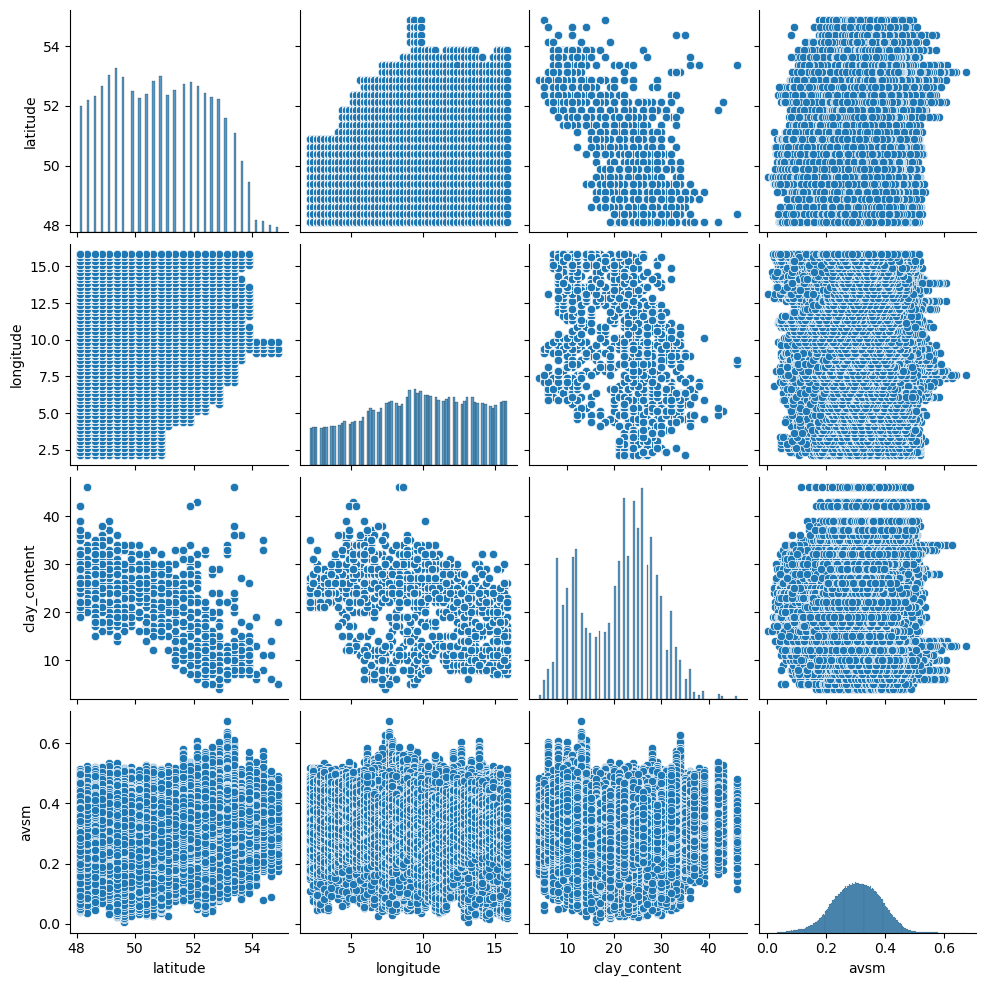

In [42]:
sns.pairplot(df)

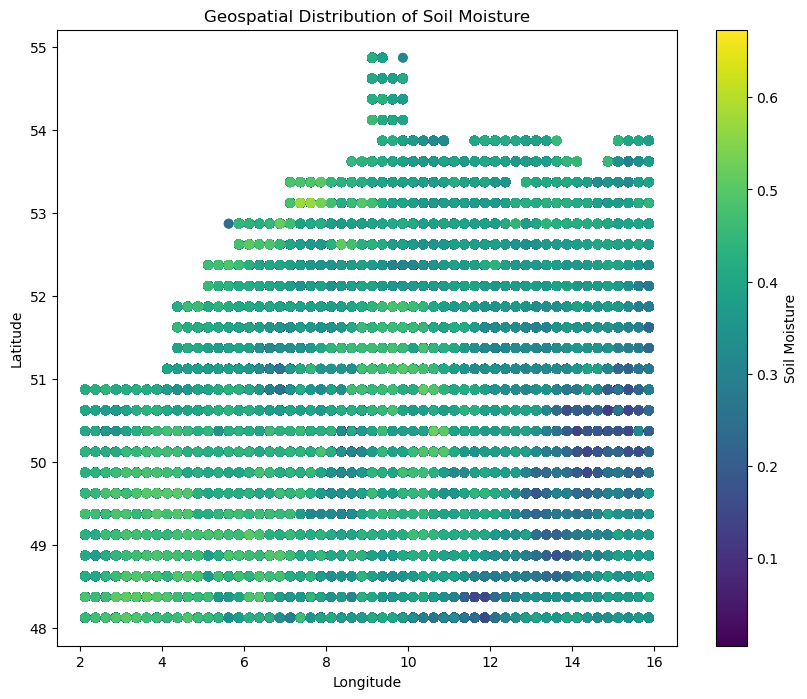

In [44]:
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], c=df['avsm'], cmap='viridis')
plt.colorbar(label='Soil Moisture')
plt.title('Geospatial Distribution of Soil Moisture')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<Axes: >

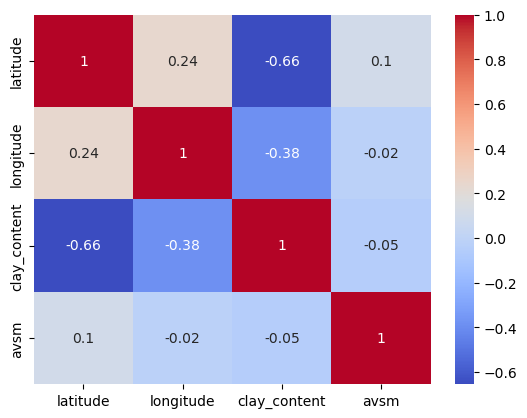

In [223]:
sns.heatmap(df.select_dtypes('number').corr(), cmap='coolwarm', annot=True)

### Soil Moisture Distribution

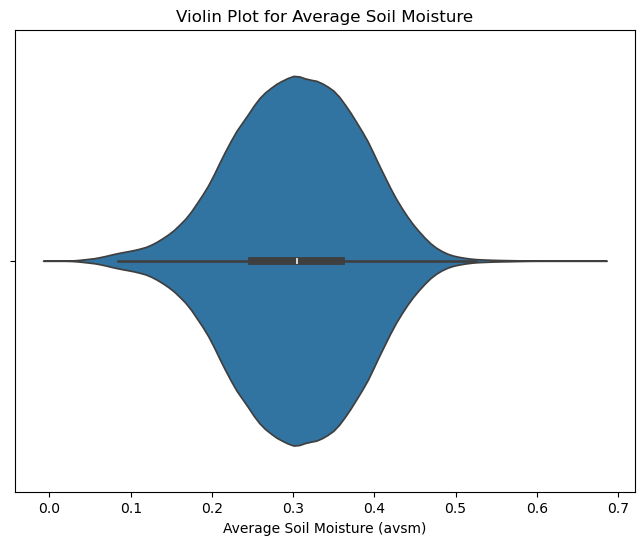

In [49]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['avsm'])
plt.title('Violin Plot for Average Soil Moisture')
plt.xlabel('Average Soil Moisture (avsm)')
plt.show()

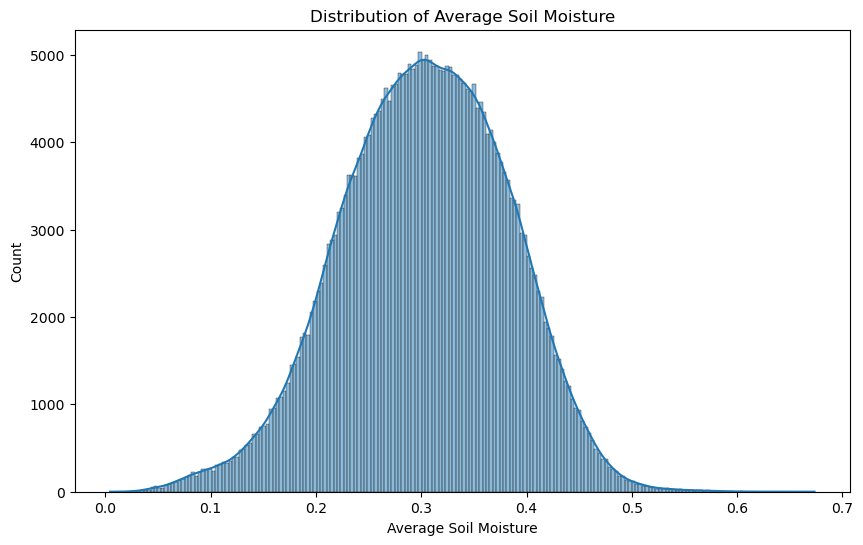

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(df['avsm'], kde=True)
plt.title('Distribution of Average Soil Moisture')
plt.xlabel('Average Soil Moisture')
plt.show()

Text(0.5, 0, 'Values')

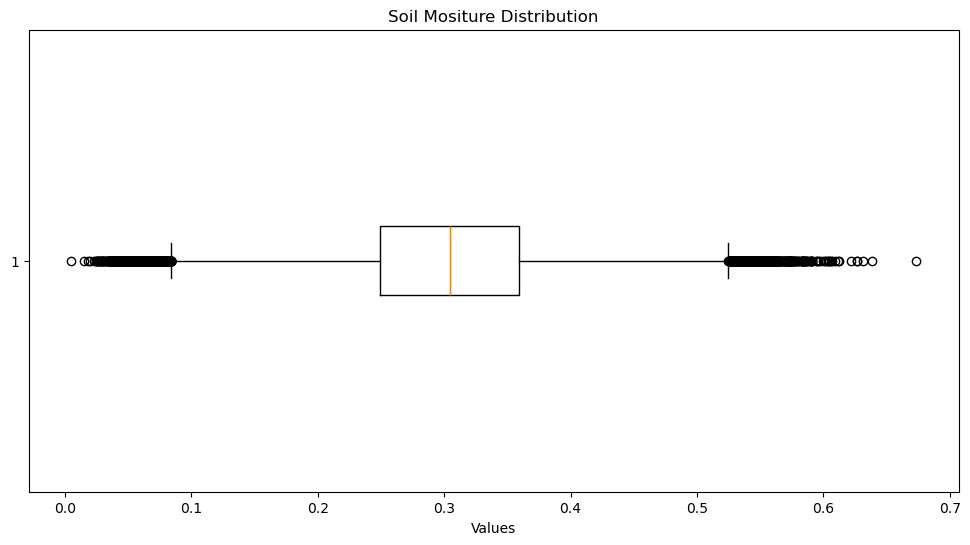

In [224]:
plt.figure(figsize=(12,6))
plt.boxplot(df['avsm'], vert=False)
plt.title('Soil Mositure Distribution')
plt.xlabel('Values')

In [225]:
Q1 = df['avsm'].quantile(0.25)
Q3 = df['avsm'].quantile(0.75)
IQR = Q3 - Q1

df['avsm'] = df['avsm'].where((df['avsm'] >= (Q1 - 1.5 * IQR)) & (df['avsm'] <= (Q3 + 1.5 * IQR)), pd.NA)

In [226]:
df.fillna(method='ffill', inplace=True)

## Model Preparation

In [227]:
X = df.drop(columns='avsm')
y = df['avsm']

In [228]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [229]:
baseline = y_train.mean()
y_pred_baseline = [baseline] * len(y_train)
mean_absolute_error(y_train, y_pred_baseline)

0.06319654875217962

In [230]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [231]:
X.shape

(321584, 3)

## Model Architecture

In [232]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, input_shape = (3, 1), return_sequences=True),
  tf.keras.layers.LSTM(64),

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),

  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),

  tf.keras.layers.Dense(1, activation='linear')
])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 3, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 639,361 (2.44 MB)

 Trainable params: 639,361 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

In [233]:
model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

## Model Training

In [234]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128,validation_data=(X_val, y_val))

Epoch 1/20


2010/2010 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - loss: 0.0077 - mean_absolute_error: 0.0680 - val_loss: 0.0060 - val_mean_absolute_error: 0.0630
Epoch 2/20
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - loss: 0.0057 - mean_absolute_error: 0.0614 - val_loss: 0.0054 - val_mean_absolute_error: 0.0599
Epoch 3/20
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0053 - mean_absolute_error: 0.0596 - val_loss: 0.0051 - val_mean_absolute_error: 0.0584
Epoch 4/20
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0052 - mean_absolute_error: 0.0588 - val_loss: 0.0051 - val_mean_absolute_error: 0.0588
Epoch 5/20
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0051 - mean_absolute_error: 0.0587 - val_loss: 0.0051 - val_mean_absolute_error: 0.0582
Epoch 6/20
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0051 - mean_absolute_error: 0.0583 - val_loss: 0.0051 - val_mean_absolute_error: 0.0583
Epoch 7/20
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 0.0050 - mean_absolute_

## Model Evaluation

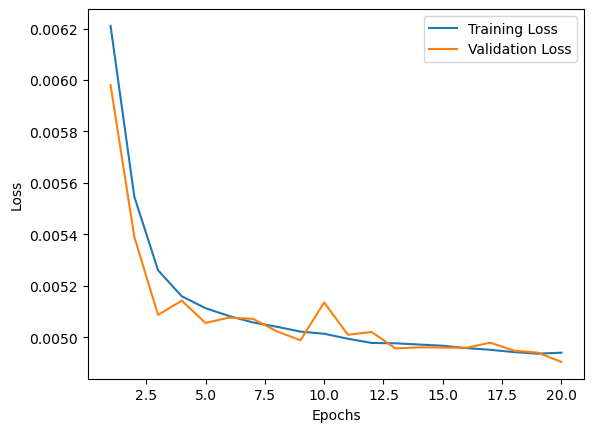

In [235]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predictions

In [236]:
y_pred = model.predict(X_test)

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [237]:
y_pred = y_pred.reshape(-1,)

In [238]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

MAE: 0.0576


<Axes: xlabel='time'>

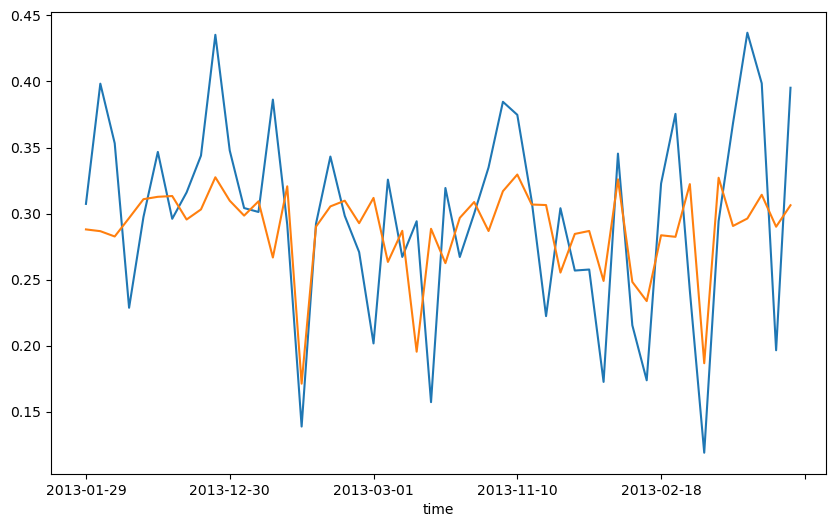

In [239]:
plt.figure(figsize=(10, 6))
y_test.head(50).plot(kind='line')
predictions = pd.Series(y_pred)
predictions[:50].plot(kind='line')

In [244]:
# with open ('model.h5', 'wb') as m:
#     pickle.dump(model, m)